In [ ]:
!pip install -q tensorflow-recommenders
!pip install -q --upgrade tensorflow-datasets
!pip install -q tensorflow-ranking

import tensorflow_datasets as tfds
import tensorflow_ranking as tfr
import tensorflow_recommenders as tfrs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import math
import random
from random import seed
from random import randrange
from csv import reader
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
SGD = tf.keras.optimizers.SGD()
from tensorflow.keras.optimizers import Adam,Nadam, SGD
from tensorflow.keras.utils import to_categorical
import sklearn.metrics
from sklearn.metrics import classification_report
#import tensorflow_recommenders as tfrs


In [6]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Load the dataset
df = pd.read_csv('gdrive/MyDrive/SE_Project_NNLRank/Successful_Failed_Onboarding.csv')
#df = pd.read_csv('gdrive/MyDrive/SE Project Dataset/Successful_Failed_Onboarding.csv')
'''for i in df.columns[df.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    df[i].fillna(df[i].mean(),inplace=True)'''
#df.replace(0,np.nan, inplace = True)
df = df.fillna(df.mean())
df.head()
#print(df)

Mounted at /content/gdrive


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # Remove the CWD from sys.path while we load stuff.


,project_id,owner_id,user_id,Time_Create,Time_Meb0,Time_Meb1,Time_Cmt0,Time_Cmt1,project_language,Tech_lang,Project_Member,Project_Commit_Count,Project_Size,Open_Issues_Count,Forks,Watchers,Network_Count,Stargazers_Count,has_star_developer,Successful_Onboarding
0,202,1653,1662,119,0,649796,20239,2896337,JavaScript,4,195,52227,999796.0,683.0,683.0,2331.0,2092.0,226.0,1,1
1,392,2997,138128,60,0,3316225,65,2097657,JavaScript,2,122,17900,92974.0,2791.0,2791.0,8180.0,33671.0,1602.0,1,0
2,392,2997,2028259,60,0,3316225,65,2097657,JavaScript,2,122,17900,92974.0,2791.0,2791.0,8180.0,33671.0,1602.0,1,1
3,540,3797,36361,120,0,2355387,6140,2095492,JavaScript,3,10,15531,74341.0,429.0,429.0,4272.0,22163.0,903.0,1,1
4,544,4233,4334,119,0,369290,1244705,2106930,JavaScript,7,16,6625,41122.0,111.0,111.0,308.0,2152.0,63.0,1,1


In [7]:
# Dataset preprocessing
#list of columns that used for training and testing
column_name=list(df.iloc[:,np.r_[0,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19]])

print("Features and Targets:",column_name)

pro_data=df[column_name].to_numpy()

X=pro_data[:,:16]
y=pro_data[:,-1]

'''X[X == 0] = 'nan'

col_mean = np.nanmean(X, axis=0)
inds = np.where(np.isnan(X))
X[inds] = np.take(col_mean, inds[1])'''

x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=20)



Features and Targets: ['project_id', 'user_id', 'Time_Create', 'Time_Meb0', 'Time_Meb1', 'Time_Cmt0', 'Time_Cmt1', 'Tech_lang', 'Project_Member', 'Project_Commit_Count', 'Project_Size', 'Open_Issues_Count', 'Forks', 'Watchers', 'Network_Count', 'Stargazers_Count', 'has_star_developer', 'Successful_Onboarding']


In [8]:
#scaler = preprocessing.StandardScaler()
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [9]:
x_train[0]

array([1.23037466e-01, 1.22456965e-03, 1.14186622e-05, 0.00000000e+00,
       0.00000000e+00, 1.49105986e-03, 2.13310952e-01, 1.53846154e-01,
       2.54110613e-02, 6.10076096e-04, 3.94759854e-05, 7.60745531e-04,
       7.60745531e-04, 1.73334748e-03, 4.98866610e-04, 3.30695642e-03])

In [10]:
def arctan(self, x, derivative=False):
        if (derivative == True):
            return (tf.math.cos(x) ** 2)
        return tf.math.atan(x)

from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def mAP(y_true,y_pred):
	num_classes = y_true.shape[1]
	average_precisions = []
	relevant = K.sum(K.round(K.clip(y_true, 0, 1)))
	tp_whole = K.round(K.clip(y_true * y_pred, 0, 1))
	for index in range(num_classes):
		temp = K.sum(tp_whole[:,:index+1],axis=1)
		average_precisions.append(temp * (1/(index + 1)))
	AP = K.sum(average_precisions) / relevant
	mAP = K.mean(AP,axis=0)
	return mAP

def weighted_binary_crossentropy(self, y_true, y_pred):
    logloss = -(y_true * K.log(y_pred) * self.weights[0] + \
               (1 - y_true) * K.log(1 - y_pred) * self.weights[1])

    return K.mean(logloss, axis=-1)


In [11]:
def fit_model(trainX, trainy, testX, testy, n_batch):
	# define model
  model = Sequential()
  model.add(Dense(5, activation='relu', kernel_initializer='random_normal',bias_initializer='zeros'))
  model.add(Dense(5, activation='relu'))
  #model.add(Dense(5,input_dim=5, activation='sigmoid')
  model.add(Dense(1, activation='sigmoid'))
 

  

	# compile model
  
  opt = SGD(learning_rate=0.01)
  #model.compile(loss=tfr.keras.losses.ListMLELoss(lambda_weight=1.0), optimizer=opt, metrics=['accuracy',precision_m,recall_m,f1_m])
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=['accuracy',precision_m,recall_m,f1_m, tfr.keras.metrics.MeanAveragePrecisionMetric(name=None, topn=None, dtype=None, ragged=False)])
  #model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=opt, metrics=['accuracy',precision_m,recall_m,f1_m])
  # fit model
  history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=10, verbose=0, batch_size=n_batch)
  #history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=10, verbose=0)

  
  loss, accuracy, precision, recall,f1_score,map = model.evaluate(testX, testy, verbose=0)
  
  print('\n')
  print('prediction score for NNLRank at: ',n_batch)
  print('accuracy:',accuracy *100, 'f1_score:',f1_score)
  print('precision:',precision, 'recall:',recall)
  print('Loss:',loss,'MAP:',map)
  #print('report:',report)
  print('\n')

	# plot learning curves
  # plot loss history
  
  plt.plot(history.history['accuracy'], label='train')
  plt.plot(history.history['val_accuracy'], label='test')
  plt.title('batch='+str(n_batch), pad=-40)
  
  # show learning curves
  plt.show()




prediction score for NNLRank at:  4
accuracy: 0.5995262861251831 f1_score: 0.6501407623291016
precision: 0.6276732683181763 recall: 0.6889462471008301
Loss: 0.6605216860771179 MAP: 0.556608259677887




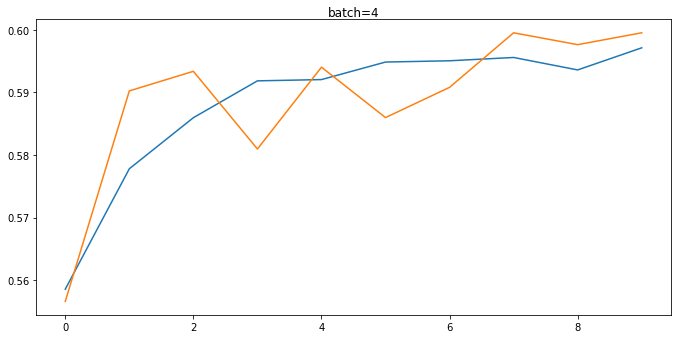



prediction score for NNLRank at:  8
accuracy: 0.5975366830825806 f1_score: 0.6937220692634583
precision: 0.5985090136528015 recall: 0.8422623872756958
Loss: 0.6607962250709534 MAP: 0.556608259677887




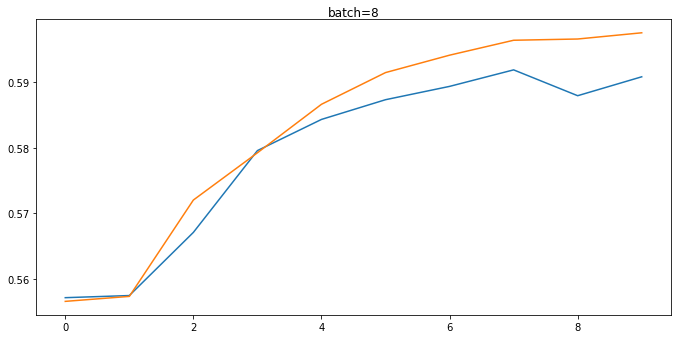



prediction score for NNLRank at:  16
accuracy: 0.5967787504196167 f1_score: 0.684066653251648
precision: 0.6025946140289307 recall: 0.806575357913971
Loss: 0.6609473824501038 MAP: 0.556608259677887




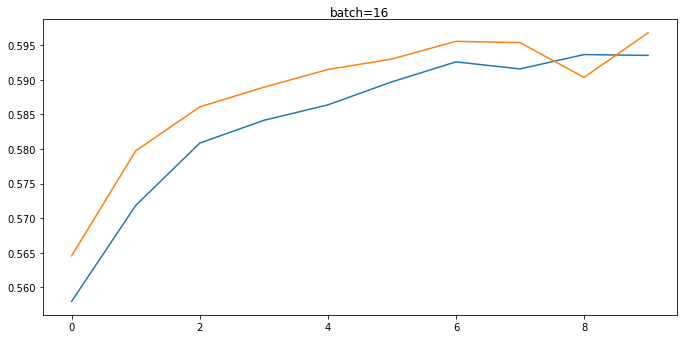



prediction score for NNLRank at:  32
accuracy: 0.5701563358306885 f1_score: 0.7114209532737732
precision: 0.5660529732704163 recall: 0.9751323461532593
Loss: 0.6776884198188782 MAP: 0.556608259677887




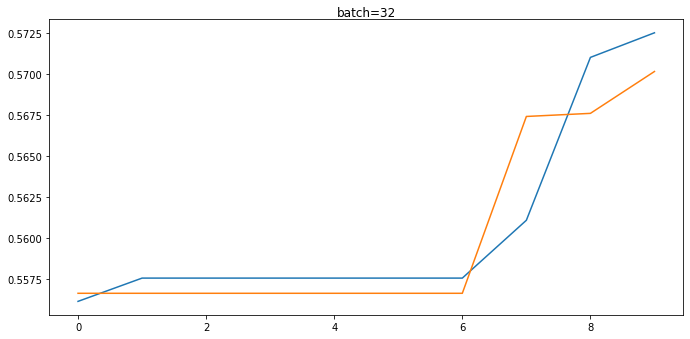

In [ ]:
# create learning curves for different batch sizes

batch_sizes = [4,8,16,32]
for i in range(len(batch_sizes)):
	# determine the plot number
	plt.figure(figsize=(25, 25))
	plot_no = 420 + (i+1)
	plt.subplot(plot_no)
 
	# fit model and plot learning curves for a batch size
	fit_model(x_train,y_train,x_test,y_test, batch_sizes[i])
  
# show learning curves
#plt.show()